## Problem Statement

This project aims to forecast sugar prices in Bangladesh using four years of historical time series data. Accurate price predictions can help market participants make better decisions and manage risks. The focus is on building a machine learning model that captures trends and seasonality to provide reliable short-term forecasts.

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

In [108]:
df = pd.read_csv('data/sugar_prices.csv')
df.head()

,Date,category,item,unit,min_price,max_price
0,2021-05-17,Miscellaneous,Sugar,per kg,70,75
1,2021-05-18,Miscellaneous,Sugar,per kg,70,75
2,2021-05-20,Miscellaneous,Sugar,per kg,70,75
3,2021-05-21,Miscellaneous,Sugar,per kg,70,75
4,2021-05-22,Miscellaneous,Sugar,per kg,70,75


The data has 6 columns:
- **Date**: the date prices were collected on
- **category**: the category of the item
- **item**: the item name
- **unit**: unit of measure
- **min_price**: minimum price found on the day
- **max_price**: maximum price found on the day

## Splitting into train and test dataset

In [109]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

## Data Inspaction

### Checking null values

In [110]:
for col in train.columns:
    print(f"{col}: {train[col].isna().sum()} null values")

Date: 0 null values
category: 0 null values
item: 0 null values
unit: 0 null values
min_price: 0 null values
max_price: 0 null values


The columns don't contain any null values

### Checking data types

In [111]:
for col in train.columns:
    print(f"{col}: {train[col].dtype}")

Date: object
category: object
item: object
unit: object
min_price: int64
max_price: int64


**Observations**
- **Date** column seems to be of object type, should be converted to datetime and set as index type for better analysis
- All other columns have proper types

In [112]:
train['Date'] = pd.to_datetime(train['Date'], format="%Y-%m-%d")
train.set_index('Date', inplace=True)


In [113]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 768 entries, 2023-12-15 to 2021-10-08
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   768 non-null    object
 1   item       768 non-null    object
 2   unit       768 non-null    object
 3   min_price  768 non-null    int64 
 4   max_price  768 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 36.0+ KB


### checking unique values in categorical columns

In [114]:
cat_cols = [col for col in train.columns if train[col].dtype == 'O']

for col in cat_cols:
    unq_vals = train[col].unique()
    print(f"Column col has {len(unq_vals)} unique values:")
    for val in unq_vals:
        print(val)

Column col has 1 unique values:
Miscellaneous
Column col has 1 unique values:
Sugar
Column col has 1 unique values:
per kg


- categorical columns all hold the same values and don't provide any useful information. so they all could be dropped.
- the unit information can be kept by changing the column names for numeric columns to include unit

In [115]:
train.rename(columns={
    'min_price': 'min_price_per_kg',
    'max_price': 'max_price_per_kg'
}, inplace=True)

train.drop(columns=cat_cols, inplace=True)

In [116]:
train.head()

,min_price_per_kg,max_price_per_kg
Date,,
2023-12-15,140,150
2025-06-18,110,120
2024-03-13,140,145
2023-03-05,115,120
2021-10-17,80,82


### Inspecting numerical columns 

In [117]:
num_cols = ['min_price_per_kg', 'max_price_per_kg']

train[num_cols].describe()

,min_price_per_kg,max_price_per_kg
count,768.00000,768.000000
mean,112.39974,119.088542
std,23.10241,24.734206
min,68.00000,70.000000
25%,107.00000,115.000000
50%,120.00000,128.000000
75%,130.00000,135.000000
max,145.00000,150.000000


No unusual values detected in the numerical columns

## Data Analysis

### Primary Inspection

<Axes: xlabel='Date'>

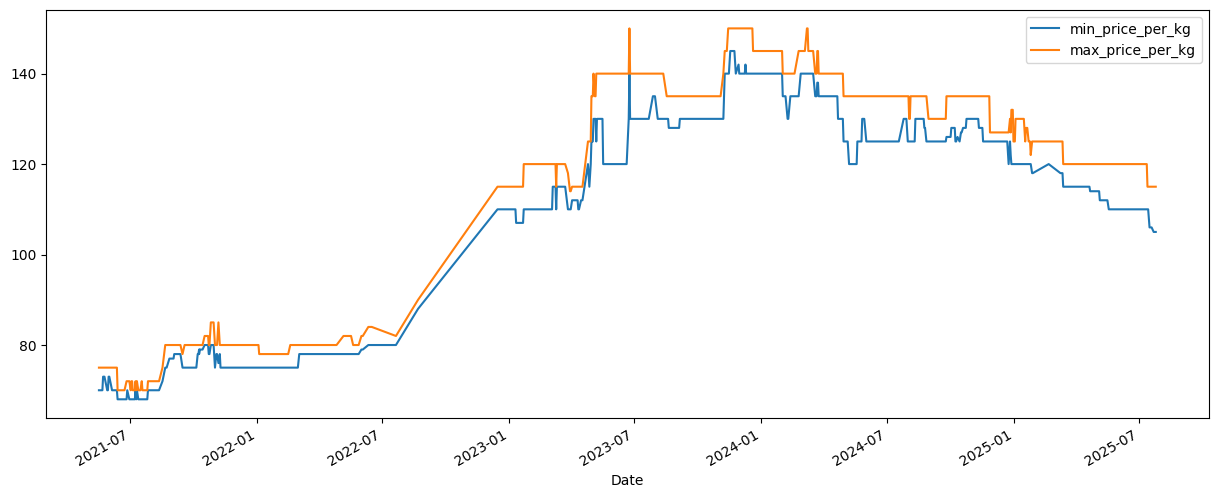

In [118]:
train.sort_index(inplace=True)

train[num_cols].plot(figsize=(15, 6))

- Data seemes to be jerky at daily level
- Smoothing out the data by taking weekly and monthly rolling averages could reveal better trends

### Weekly rolling avarage

<Axes: xlabel='Date'>

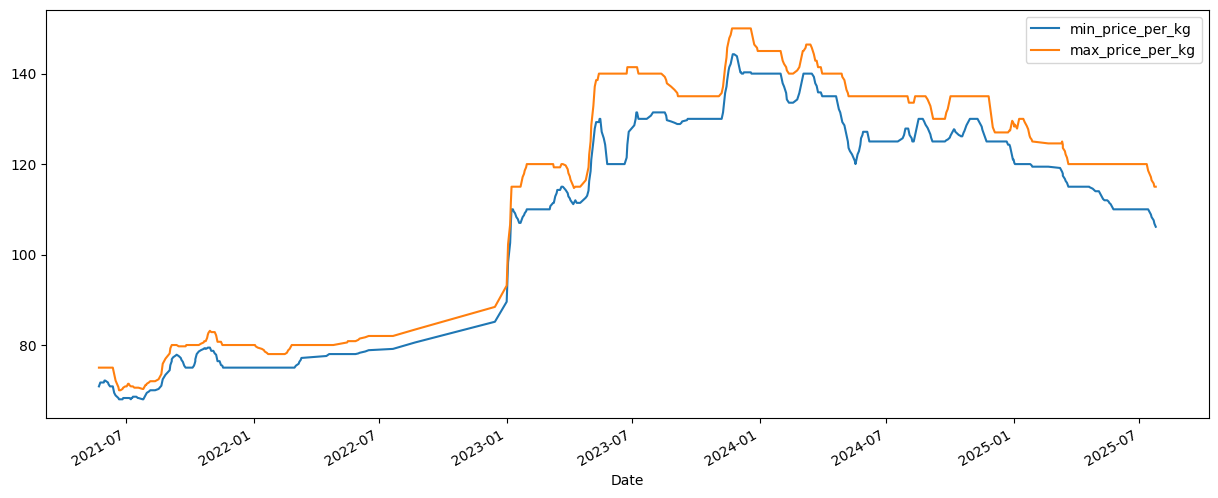

In [119]:
train[num_cols].rolling(window=7).mean().plot(figsize=(15, 6))

### Monthly rolling avarage

<Axes: xlabel='Date'>

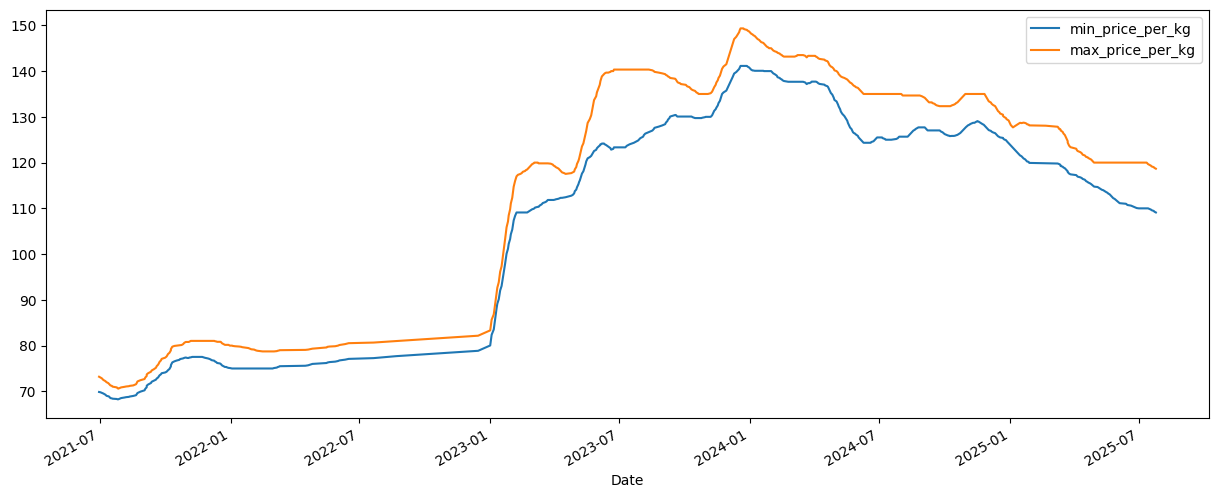

In [120]:
train[num_cols].rolling(window=30).mean().plot(figsize=(15, 6))

### Checking for trend, seasonality and residuals 

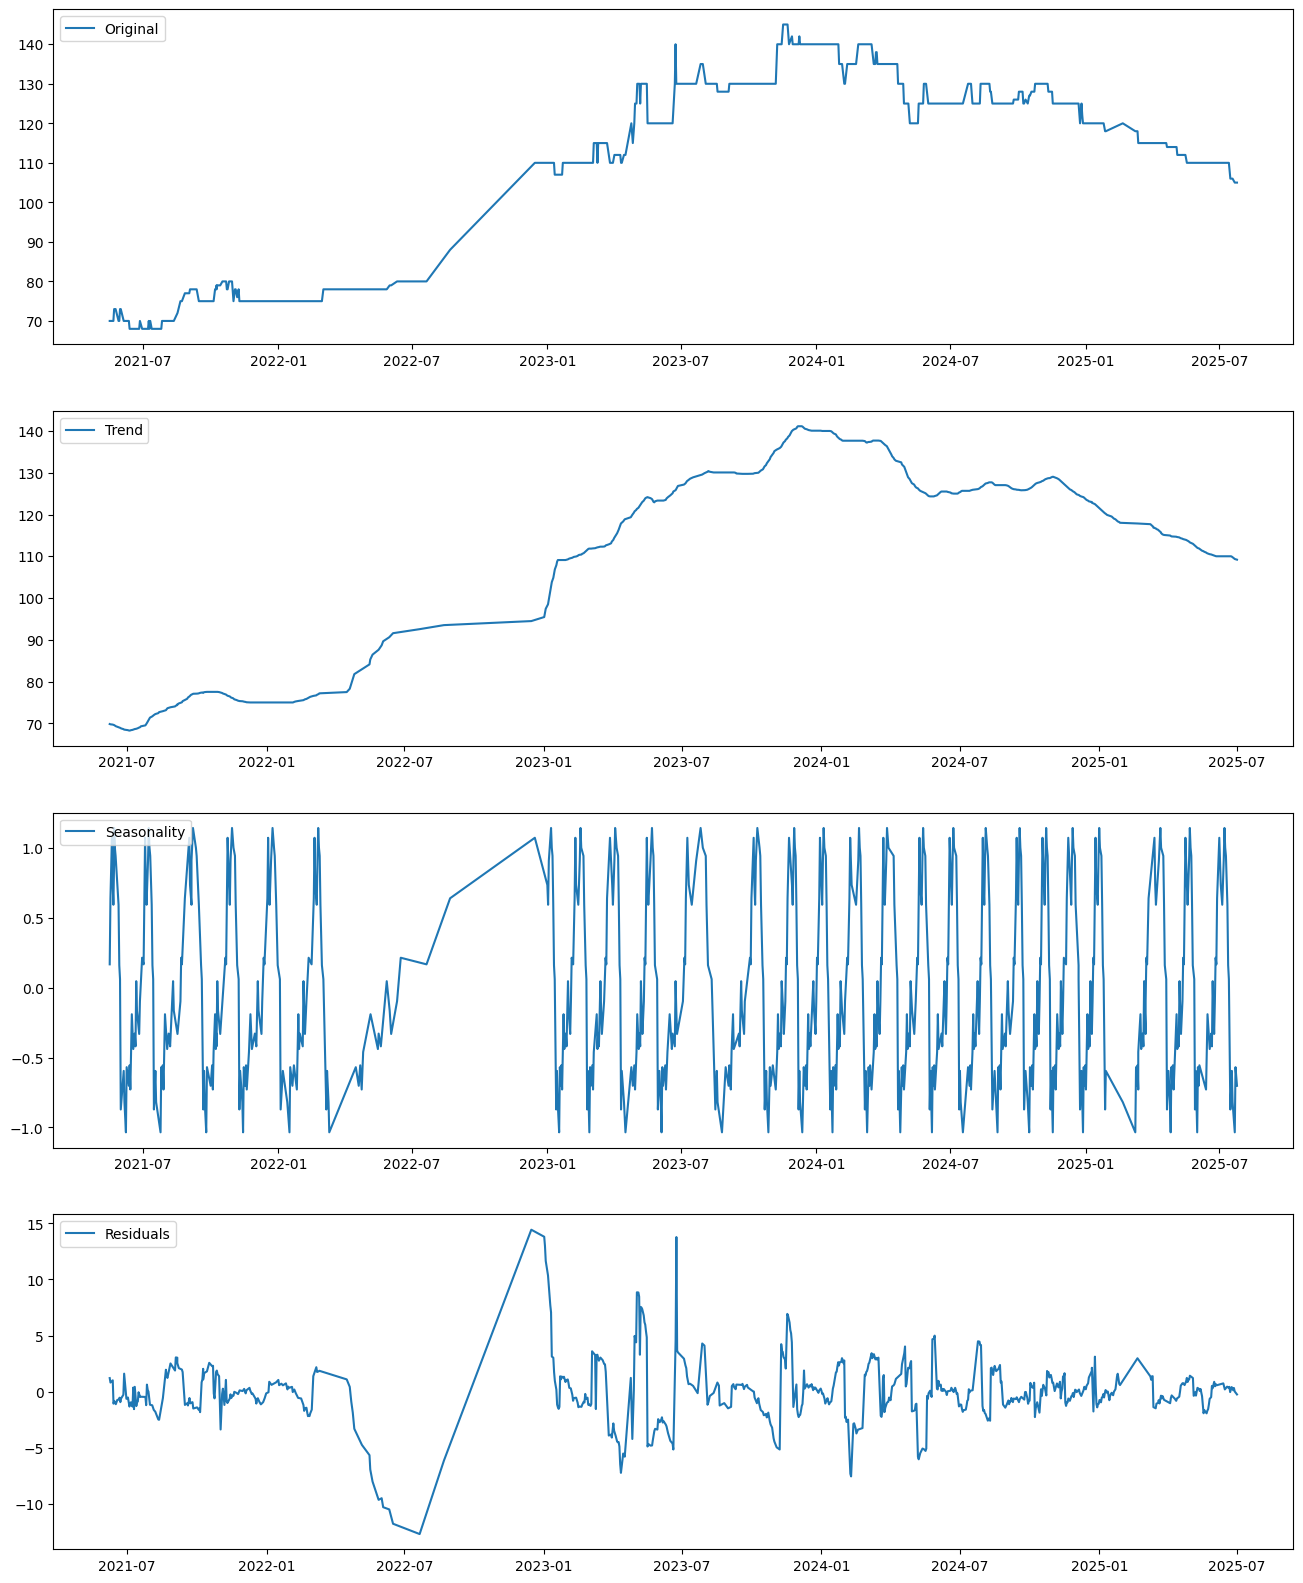

In [125]:
decomsition_additive = seasonal_decompose(train['min_price_per_kg'], model='additive', period=30)

trend_additive = decomsition_additive.trend
seasonal_additive = decomsition_additive.seasonal
residual_additive = decomsition_additive.resid

plt.figure(figsize=(16, 20))

plt.subplot(411)
plt.plot(train['min_price_per_kg'], label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend_additive, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal_additive, label='Seasonality')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual_additive, label='Residuals')
plt.legend(loc='upper left')

- data shows a general upward trend
- data shows seasonal trend except for the time from **2022-06 to 2023-01**
- residuals are mostly constant except for the time **2022-06 to 2023-01**